# Data splitters

Splitting your data in a Machine Learning pipeline is a crucial step. It is important to make sure that the data is split in a way that the model is not overfitting. In this tutorial we will show you how to use the splitters in DeepMol. Some splitters allow us to have an easier task for a model to learn, while others allow us to have a more difficult task for a model to learn. We will show you how to use the splitters and how to use them in a pipeline.

## Import data

In [ ]:
from deepmol.splitters import SingletaskStratifiedSplitter
from deepmol.loaders import CSVLoader
from deepmol.splitters import SimilaritySplitter

from deepmol.compound_featurization import MorganFingerprint

from deepmol.models import SklearnModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from deepmol.metrics import Metric

In [21]:
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def generate_tsne_molecular_similarities(train_dataset, valid_dataset, test_dataset):
    # Create a function to compute molecular fingerprints
    def compute_fingerprint(smiles):
        molecule = Chem.MolFromSmiles(smiles)
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(molecule, 2, nBits=1024)
        return fingerprint

    # Compute molecular fingerprints for each molecule in the combined dataset
    fingerprints = [compute_fingerprint(smiles) for smiles in train_dataset.smiles]
    fingerprints.extend([compute_fingerprint(smiles) for smiles in valid_dataset.smiles])
    fingerprints.extend([compute_fingerprint(smiles) for smiles in test_dataset.smiles])

    similarity_matrix = np.zeros((len(fingerprints), len(fingerprints)))
    # Compute molecular similarities using Tanimoto coefficient
    for i in range(len(fingerprints)):
        for j in range(i + 1, len(fingerprints)):
            similarity = DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity

    # Apply t-SNE to reduce the dimensionality
    tsne = TSNE(n_components=2, random_state=42)
    tsne_embeddings = tsne.fit_transform(similarity_matrix)
    # Separate the embeddings based on the original datasets
    dataset1_embeddings = tsne_embeddings[:len(train_dataset.smiles)]
    dataset2_embeddings = tsne_embeddings[len(train_dataset.smiles):len(valid_dataset.smiles) + len(train_dataset.smiles)]
    dataset3_embeddings = tsne_embeddings[len(valid_dataset.smiles) + len(train_dataset.smiles):]

    # Plot the embeddings with different colors for each dataset
    plt.scatter(dataset1_embeddings[:, 0], dataset1_embeddings[:, 1], c='red', label='Train dataset')
    plt.scatter(dataset2_embeddings[:, 0], dataset2_embeddings[:, 1], c='blue', label='Validation dataset')
    plt.scatter(dataset3_embeddings[:, 0], dataset3_embeddings[:, 1], c='green', label='Test dataset')
    plt.legend()
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title('Molecular Similarities with t-SNE')
    plt.show()

In [2]:
dataset = CSVLoader("../data/CHEMBL217_reduced.csv", id_field="Original_Entry_ID",
                    smiles_field="SMILES", labels_fields=["Activity_Flag"]).create_dataset()

2023-05-30 14:44:57,728 — ERROR — Molecule with smiles: ClC1=C(N2CCN(O)(CC2)=C/C=C/CNC(=O)C=3C=CC(=CC3)C4=NC=CC=C4)C=CC=C1Cl removed from dataset.
2023-05-30 14:44:57,729 — INFO — Assuming classification since there are less than 10 unique y values. If otherwise, explicitly set the mode to 'regression'!


[14:44:57] Explicit valence for atom # 6 N, 5, is greater than permitted


# Splitters

## SingletaskStratifiedSplitter

In [3]:
splitter = SingletaskStratifiedSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset, frac_train=0.8, frac_valid=0.1, frac_test=0.1)

In [4]:
train_dataset.get_shape()

2023-05-30 14:46:44,089 — INFO — Mols_shape: (13316,)
2023-05-30 14:46:44,090 — INFO — Features_shape: None
2023-05-30 14:46:44,091 — INFO — Labels_shape: (13316,)


((13316,), None, (13316,))

In [5]:
valid_dataset.get_shape()

2023-05-30 14:46:47,234 — INFO — Mols_shape: (1664,)
2023-05-30 14:46:47,235 — INFO — Features_shape: None
2023-05-30 14:46:47,236 — INFO — Labels_shape: (1664,)


((1664,), None, (1664,))

In [6]:
test_dataset.get_shape()

2023-05-30 14:46:50,442 — INFO — Mols_shape: (1665,)
2023-05-30 14:46:50,443 — INFO — Features_shape: None
2023-05-30 14:46:50,444 — INFO — Labels_shape: (1665,)


((1665,), None, (1665,))

/home/bisbii/anaconda3/envs/deepmol/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/bisbii/anaconda3/envs/deepmol/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


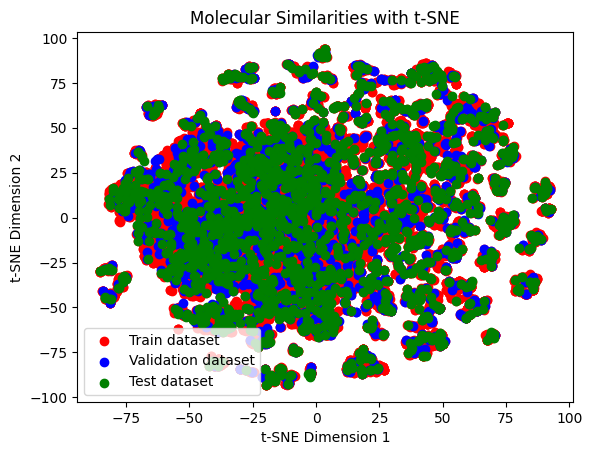

In [22]:
generate_tsne_molecular_similarities(train_dataset, valid_dataset, test_dataset)

In [6]:
MorganFingerprint().featurize(train_dataset)
MorganFingerprint().featurize(valid_dataset)
MorganFingerprint().featurize(test_dataset)

rf = RandomForestClassifier()
model = SklearnModel(model=rf)
model.fit(train_dataset)

RandomForestClassifier()

In [7]:
model.evaluate(test_dataset, [Metric(accuracy_score, name="accuracy")])

({'accuracy': 0.984984984984985}, {})

## Similarity Splitter

In [11]:
similarity_splitter = SimilaritySplitter()

train_dataset, valid_dataset, test_dataset = similarity_splitter.train_valid_test_split(dataset, frac_train=0.8, frac_valid=0.1, frac_test=0.1, homogenous_threshold=0.15)

In [12]:
train_dataset.get_shape()
valid_dataset.get_shape()
test_dataset.get_shape()

2023-03-17 18:59:56,556 — INFO — Mols_shape: (13315,)
2023-03-17 18:59:56,557 — INFO — Features_shape: None
2023-03-17 18:59:56,557 — INFO — Labels_shape: (13315,)
2023-03-17 18:59:56,558 — INFO — Mols_shape: (1664,)
2023-03-17 18:59:56,558 — INFO — Features_shape: None
2023-03-17 18:59:56,559 — INFO — Labels_shape: (1664,)
2023-03-17 18:59:56,559 — INFO — Mols_shape: (1666,)
2023-03-17 18:59:56,559 — INFO — Features_shape: None
2023-03-17 18:59:56,560 — INFO — Labels_shape: (1666,)


((1666,), None, (1666,))

In [13]:
MorganFingerprint().featurize(train_dataset)
MorganFingerprint().featurize(valid_dataset)
MorganFingerprint().featurize(test_dataset)

rf = RandomForestClassifier()
model = SklearnModel(model=rf)
model.fit(train_dataset)
model.evaluate(test_dataset, [Metric(accuracy_score, name="accuracy")])

({'accuracy': 0.978391356542617}, {})

In [14]:
train_dataset, valid_dataset, test_dataset = similarity_splitter.train_valid_test_split(dataset, frac_train=0.8, frac_valid=0.1, frac_test=0.1, homogenous_threshold=0.90)

In [15]:
MorganFingerprint().featurize(train_dataset)
MorganFingerprint().featurize(valid_dataset)
MorganFingerprint().featurize(test_dataset)

rf = RandomForestClassifier()
model = SklearnModel(model=rf)
model.fit(train_dataset)
model.evaluate(test_dataset, [Metric(accuracy_score, name="accuracy")])

({'accuracy': 0.7725090036014406}, {})

## Scaffold Splitter

In [18]:
from deepmol.splitters import ScaffoldSplitter

scaffold_splitter = ScaffoldSplitter()

train_dataset, valid_dataset, test_dataset = scaffold_splitter.train_valid_test_split(dataset, frac_train=0.8, frac_valid=0.1, frac_test=0.1, homogenous_datasets = True)

In [19]:
MorganFingerprint().featurize(train_dataset)
MorganFingerprint().featurize(valid_dataset)
MorganFingerprint().featurize(test_dataset)

rf = RandomForestClassifier()
model = SklearnModel(model=rf)
model.fit(train_dataset)
model.evaluate(test_dataset, [Metric(accuracy_score, name="accuracy")])

({'accuracy': 0.978391356542617}, {})

In [20]:
train_dataset, valid_dataset, test_dataset = scaffold_splitter.train_valid_test_split(dataset, frac_train=0.8, frac_valid=0.1, frac_test=0.1, homogenous_datasets = False)

In [21]:
MorganFingerprint().featurize(train_dataset)
MorganFingerprint().featurize(valid_dataset)
MorganFingerprint().featurize(test_dataset)

rf = RandomForestClassifier()
model = SklearnModel(model=rf)
model.fit(train_dataset)
model.evaluate(test_dataset, [Metric(accuracy_score, name="accuracy")])

({'accuracy': 0.963985594237695}, {})